In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
DatabaseDF = pd.read_csv('../CleanedDataset.csv')

## Definition

A very important part of our dataset is understanding it temporaly as well as spacially. The wells we are analyzing were drilled over the span of about 20 years and are therefore not equal in that sense, and taking into account **when** they were built is increadibly important. In this notebook I will attempt to find any correlation between when the wells were drilled and other features

## Overview / Data Cleanup

In [3]:
from datetime import datetime

In [4]:
DateDF = DatabaseDF[DatabaseDF['Date Fracd'].notna()]

datetimeList = []

for index,row in DateDF.iterrows():
    datetimeList.append(datetime.strptime(str(row['Date Fracd']),'%Y-%m-%d'))

DateDF['DateTimeObject'] = datetimeList

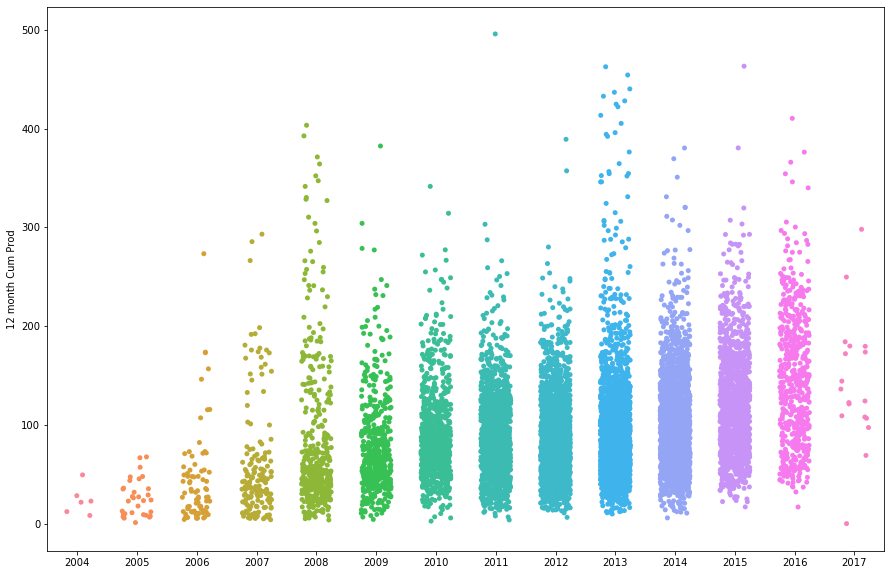

In [5]:
plt.subplots(figsize = (15,10))
xList = []

for xi in DateDF['DateTimeObject']:
    xList.append(int(xi.strftime('%Y')))

sns.stripplot(x = xList, y = DateDF['12 month Cum Prod'], jitter = .25)

This was mainly to see the size of the data we were dealing with in terms of year distribution, and clarly shows that as the years go more and more wells are being drilled. There is a noticible drop off after about 2015 however which means that we likely dont have access to the newest of datasets. It is also important to note that upon first glance it appears oil production is increasing every year, something we will look into later

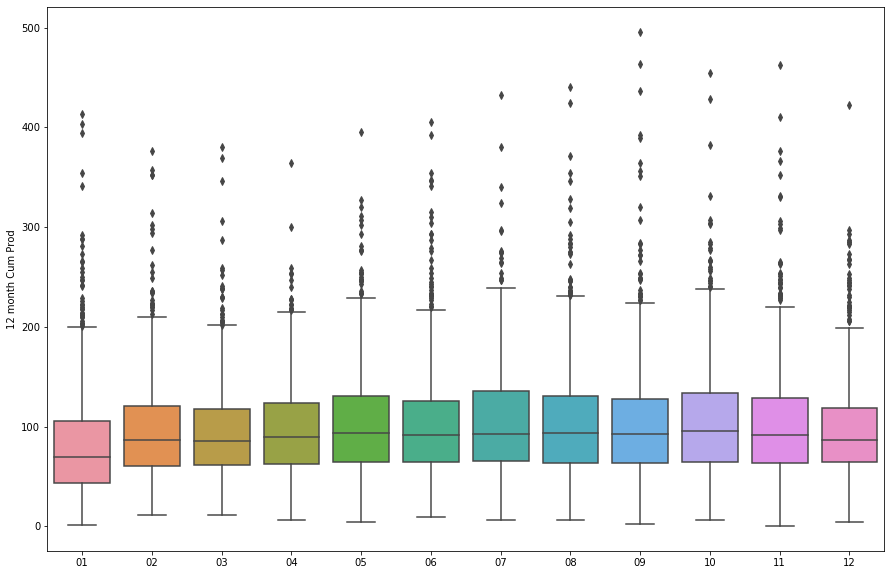

In [6]:
plt.subplots(figsize = (15,10))
xList = []

for xi in DateDF['DateTimeObject']:
    xList.append(xi.strftime('%m'))

sns.boxplot(x = xList, y = DateDF['12 month Cum Prod'])

This time I wanted to analyze months to see if certain months tended to mean more production, however at least at first glance this is not the case. Perhaps it would be better to look at which months are popular for drilling in general but this will be analyzed later

## Creating the function

In order to analyze this data more efficiently I wanted to create a function that takes in time and variable parameters then attempts to fit multiple regressions on the data. this was we are able to see the types of regressions each variable follows as well as their error. I also want to have a second function that acts as a wrapper for the first for the ease of plotting. Currently I want to look at 5 types of regression, Exponential and Polynomial of degrees 2,3, and 4. I will also use Mean Absolute Error in order to determine how accurate the fits are.

In [7]:
def expFunc(x, a, b, c):
    return a * (b**x) + c

def polyDegree2(x, a, b, c):
    return a*(x**2) + b*x + c

def polyDegree3(x, a, b, c, d):
    return a*(x**3) + b*(x**2) + c*(x) + d

def polyDegree4(x, a, b, c, d, e):
    return a*(x**4) + b*(x**3) + c*(x**2) + d*(x) + e

In [8]:
from scipy.optimize import curve_fit
import random

In [9]:
def getCurves(dataframe = DateDF, xDateUnit = '%y', ylabel = '12 month Cum Prod'):
    
    ## Setup
    xList = []

    for xi in dataframe['DateTimeObject']:
        xList.append(int(xi.strftime(xDateUnit)))

    yList = dataframe[ylabel]

    cutoff = round(len(xList) * .75)

    xModel = xList[:cutoff]
    xTest = xList[cutoff:]

    yModel = yList[:cutoff]
    yTest = yList[cutoff:]

    ECurve = P2Curve = P3Curve = P4Curve = True

    Epopt = Epcov = P2popt = P2pcov = P3popt = P3pcov = P4popt = P4pcov = 0 

    ## Fitting
    try:
        Epopt, Epcov = curve_fit(expFunc, xModel, yModel)
    except:
        ECurve = False

    try:
        P2popt, P2pcov = curve_fit(polyDegree2, xModel, yModel)
    except:
        P2Curve = False

    try:
        P3popt, P3pcov = curve_fit(polyDegree3, xModel, yModel)
    except:
        P3Curve = False

    try:
        P4popt, P4pcov = curve_fit(polyDegree4, xModel, yModel)
    except:
        P4Curve = False

    ## Mean Absolute Error Calculations
    ExpSum = Poly2Sum = Poly3Sum = Poly4Sum = 0

    for x, y in zip(xTest, yTest):
        if (ECurve):
            ExpSum += abs(y - expFunc(x, Epopt[0], Epopt[1], Epopt[2]))

        if (P2Curve):
            Poly2Sum += abs(y - polyDegree2(x, P2popt[0], P2popt[1], P2popt[2]))

        if (P3Curve):
            Poly3Sum += abs(y - polyDegree3(x, P3popt[0], P3popt[1], P3popt[2], P3popt[3]))

        if (P4Curve):
            Poly4Sum += abs(y - polyDegree4(x, P4popt[0], P4popt[1], P4popt[2], P4popt[3], P4popt[4]))

    if (ECurve):
        ExpSum = ExpSum / len(xTest)
    
    if (P2Curve):
        Poly2Sum = Poly2Sum / len(xTest)

    if (P3Curve):
        Poly3Sum = Poly3Sum / len(xTest)

    if (P4Curve):
        Poly4Sum = Poly4Sum / len(xTest)

    return [ECurve, Epopt, Epcov, ExpSum] , [P2Curve, P2popt, P2pcov, Poly2Sum], [P3Curve, P3popt, P3pcov, Poly3Sum], [P4Curve, P4popt, P4pcov, Poly4Sum]


In [10]:
def plotCurves(dataframe = DateDF, xDateUnit = '%y' , xlabel = "x-axis", ylabel = '12 month Cum Prod'):

    xList = []

    for xi in dataframe['DateTimeObject']:
        xList.append(int(xi.strftime(xDateUnit)))

    yList = dataframe[ylabel]
    
    EData, P2Data, P3Data, P4Data= getCurves(dataframe = dataframe, xDateUnit= xDateUnit, ylabel = ylabel)

    ## Plotting
    plt.subplots(figsize = (15,10))
    plt.plot(xList ,yList , 'bo')

    x_plot = np.linspace(min(xList) - 1,max(xList) + 1,max(xList) + 2)

    if (bool(EData[0])):
        ELabel = "Exponential MAE: " +  str(round(EData[3],3))
        plt.plot(x_plot,expFunc(x_plot, EData[1][0], EData[1][1], EData[1][2]), 'r-', linewidth = 4, label = ELabel)
    
    if (bool(P2Data[0])):
        Poly2Label = "2nd Degree Poly MAE: " + str(round(P2Data[3],3))
        plt.plot(x_plot, polyDegree2(x_plot, P2Data[1][0], P2Data[1][1], P2Data[1][2]), 'g-', linewidth = 4, label = Poly2Label)

    if (bool(P3Data[0])):
        Poly3label = "3rd Degree Poly MAE: "+ str(round(P3Data[3],3))
        plt.plot(x_plot, polyDegree3(x_plot, P3Data[1][0], P3Data[1][1], P3Data[1][2], P3Data[1][3]), 'y-', linewidth = 4, label = Poly3label)

    if (bool(P4Data[0])):
        Poly4label = "4th Degree Poly MAE: "+ str(round(P4Data[3],3))
        plt.plot(x_plot, polyDegree4(x_plot, P4Data[1][0], P4Data[1][1], P4Data[1][2], P4Data[1][3], P4Data[1][4]), 'c-', linewidth = 4, label = Poly4label)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()


## Cummulative Oil Production

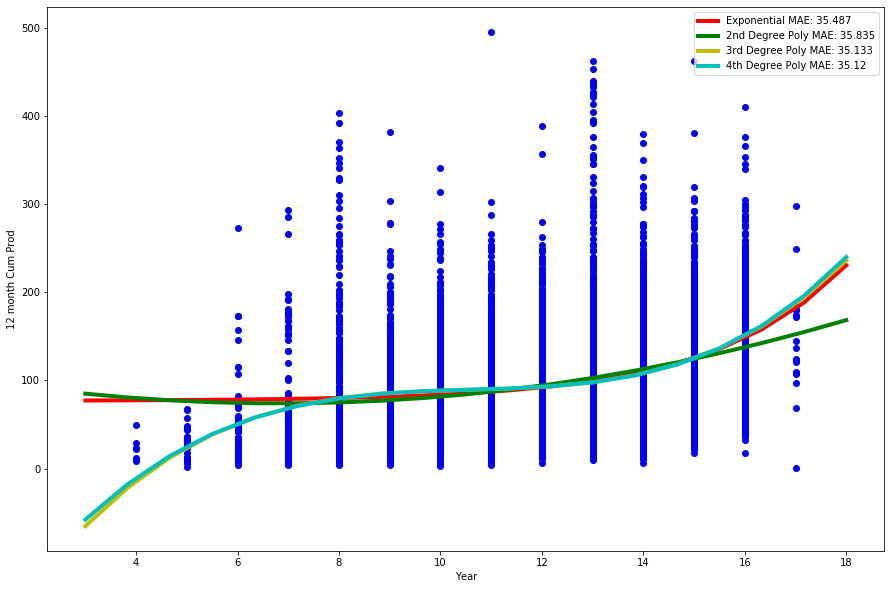

In [11]:
plotCurves(xlabel = "Year")

This shows us that with relatively low MAE we see an increase in oil production as the years go on. Something interesting to note is that the exponential functions MAE is not that much higher than that of the others meaning there is a good chance this could be following a strictly exponential path

## Plotting in other variables

I will not rapidly run this over multiple variables, not really spending a whole lot of time analyzing the results but more so gathering the data in order to begin getting a better picture

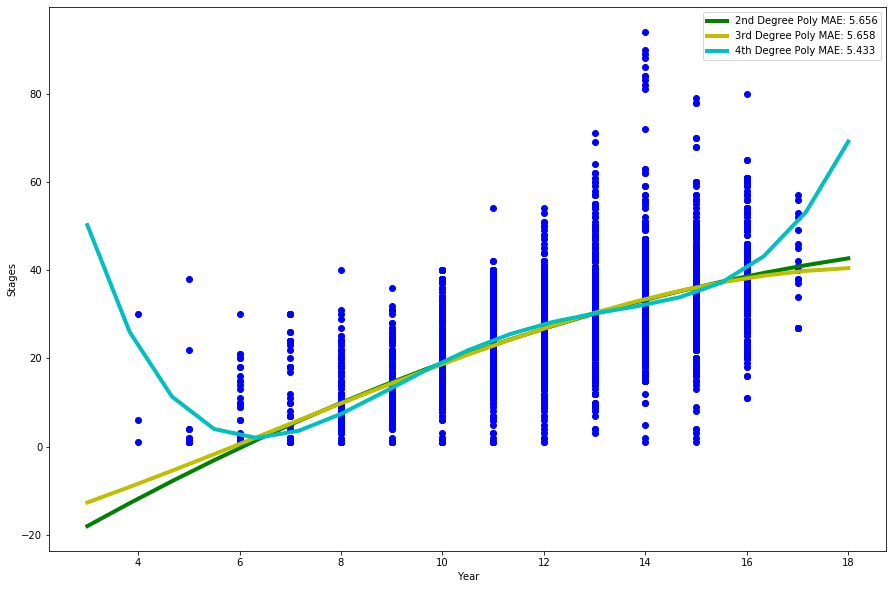

In [12]:
plotCurves(dataframe = DateDF[DateDF['Stages'].notna()], xlabel = "Year", ylabel = 'Stages')

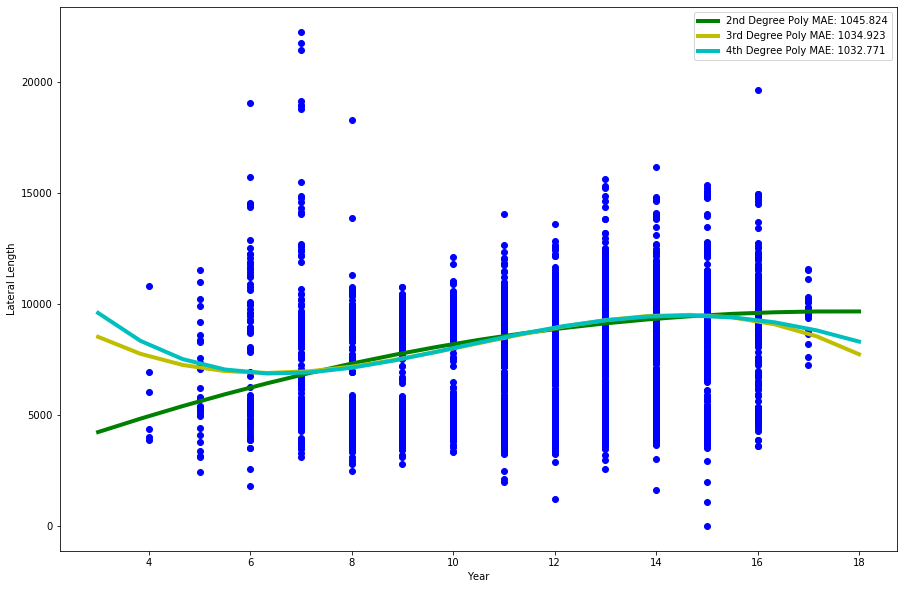

In [13]:
plotCurves(DateDF[DateDF['Lateral Length'].notna()], xlabel = "Year", ylabel = 'Lateral Length')

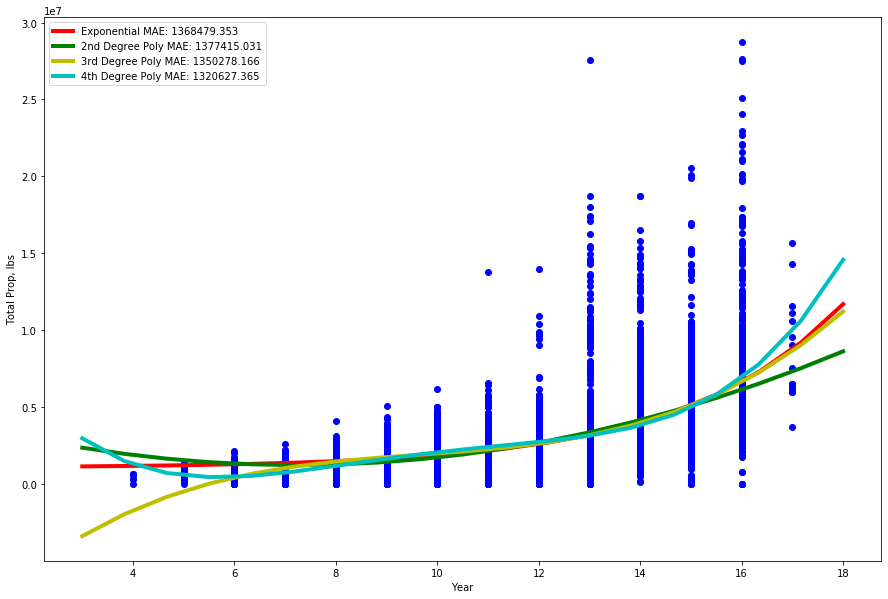

In [14]:
plotCurves(DateDF[DateDF['Total Prop, lbs'].notna()], xlabel = "Year", ylabel = 'Total Prop, lbs')

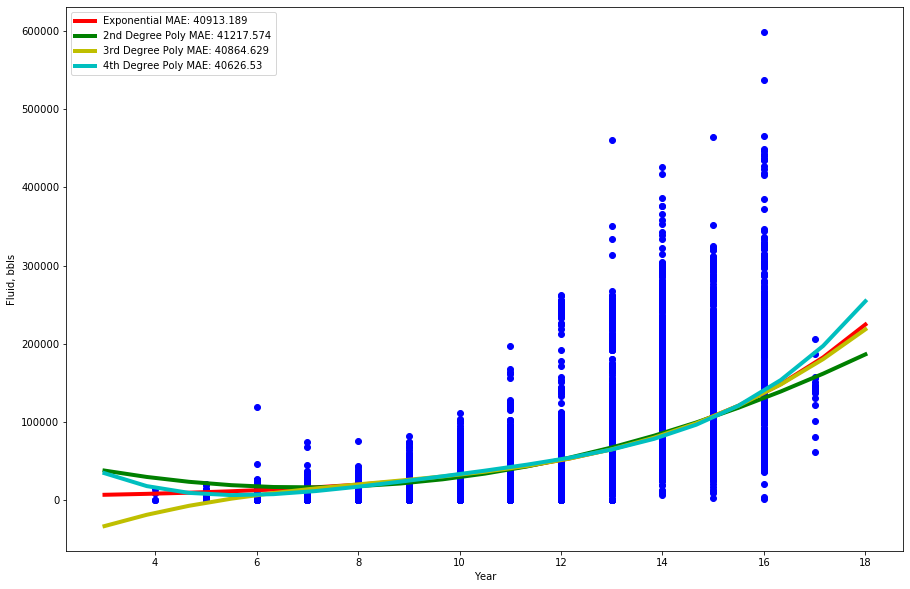

In [15]:
plotCurves(DateDF[DateDF['Fluid, bbls'].notna()], xlabel = "Year", ylabel = 'Fluid, bbls')